# Cats vs. Dogs Class dataset for multiple annotators


## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

#import sys
#sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
#sys.path.append('/input/multiple-annotators-c')
#from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

# Multiple annotators model

In [4]:

validation_data = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_Te')
train_data_MA = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_MA_sin_Tr_1')



2023-01-03 00:14:30.189688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 00:14:30.287772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 00:14:30.288576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 00:14:30.290426: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
image_count = tf.data.experimental.cardinality(train_data_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

18610

In [6]:
image_count1 = tf.data.experimental.cardinality(validation_data).numpy() # los datos de training son 18610
image_count1

4652

In [7]:
#X_test = [validation_data[i][0] for i in range(image_count1)]
#Y_true_test = [validation_data[i][1] for i in range(image_count1)]
Y_true_test = np.asarray([aux[1].numpy() for aux  in validation_data])
X_test = np.asarray([aux[0].numpy() for aux  in validation_data])

2023-01-03 00:14:33.157277: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
image_count

18610

In [9]:
val_size = int(image_count * 0.2)
train_ds_MA = train_data_MA.skip(val_size)
val_ds_MA = train_data_MA.take(val_size)

In [10]:
batch_size = 128
train_batches_MA = train_ds_MA.shuffle(1024).batch(batch_size)
val_batches_MA = val_ds_MA.shuffle(1024).batch(batch_size)
test_batches_MA = validation_data.shuffle(1024).batch(batch_size)

In [11]:
image_count = tf.data.experimental.cardinality(train_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

14888

In [12]:
image_count_val = tf.data.experimental.cardinality(val_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count_val

3722

2023-01-03 00:14:59.139476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 47 of 1024
2023-01-03 00:15:02.119370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


annotator 1
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84        63
         1.0       0.86      0.83      0.84        65

    accuracy                           0.84       128
   macro avg       0.84      0.84      0.84       128
weighted avg       0.84      0.84      0.84       128

annotator 2
              precision    recall  f1-score   support

         0.0       0.53      0.52      0.53        63
         1.0       0.55      0.55      0.55        65

    accuracy                           0.54       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.54      0.54      0.54       128

annotator 3
              precision    recall  f1-score   support

         0.0       0.62      0.63      0.63        63
         1.0       0.64      0.63      0.64        65

    accuracy                           0.63       128
   macro avg       0.63      0.63      0.63       128
weighted avg       0.63      0.63     

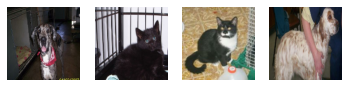

In [13]:
from sklearn.metrics import classification_report
i = 0
fig, ax = plt.subplots(1, 4)
for image, label, label2 in train_batches_MA.take(4):
   # predictedLabel = int(predictions[i] >= 0.5)
   # print(label2)
    ax[i].axis('off')
   # ax[i].set_title(classNames[label[i]])
    ax[i].imshow(image[0])
    i += 1
    for j in range(label2.shape[1]):
      print('annotator',j+1)
      print(classification_report(label ,label2[:,j]))
plt.show()

## Build the classifier from multiple annotators

In [14]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time
from tensorflow.keras import regularizers

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

class MultipleAnnotators_Classification():
    def __init__(self, output_dim, num_annotators, q= 0.0001):
        self.K = output_dim
        self.R = num_annotators
        self.q = q
        #self.callbacks #=callbacks
        #self.l1_param=l1_param 
        #self.l2_param=l1_param

    def CrowdLayer(self, input):
       #x = keras.layers.Dense(self.R + self.K, kernel_regularizer=regularizers.L1L2(l1= 1e-2, l2=1e-3),  activation='tanh')(input)
        output_cla = keras.layers.Dense(self.K,  activation='softmax')(input)
        output_ann = keras.layers.Dense(self.R,  activation='sigmoid')(input)
        output = keras.layers.Concatenate()([output_cla, output_ann])
        
        return output
#RCDNN   
    def loss(self):
        def custom_loss(y_true, y_pred):
            # print(y_true,y_pred)
            pred = y_pred[:, :self.K]
            pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
            ann_ = y_pred[:, self.K:]
            Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
            Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
            p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
            temp1 = ann_*tf.math.log(p_logreg)  
            temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
            # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
            # print(tf.reduce_mean(Y_true,axis=1).numpy())
            return -tf.math.reduce_sum((temp1 + temp2))
        return custom_loss
    
#     def loss(self):
#         def custom_loss(y_true, y_pred):
#                # print(y_true,y_pred)
#            # q = 0.1
#             pred = y_pred[:, :self.K]
#             pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
#             ann_ = y_pred[:, self.K:]
#             # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
#             Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
#             Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

#             p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
#             temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
#             temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
#             return tf.math.reduce_sum((temp1 + temp2))
#         return custom_loss

    @tf.function
    def train_step(self, x, Y, y):
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(Y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits[:, :self.K])
        return loss_value

    @tf.function
    def test_step(self, x, y):
        val_logits = self.model(x, training=False)
        self.val_acc_metric.update_state(y, val_logits[:,:self.K])

    def fit(self, model, Data_tr, Data_Val, epochs):
        self.model = model
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate an optimizer.
        #self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
        self.optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
        #self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, clipnorm=1.0)
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate a loss function.
        self.loss_fn = self.loss()
        self.train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

        train_loss = np.zeros(epochs)
        train_accur = np.zeros(epochs)
        val_accur = np.zeros(epochs)
        val_loss = np.zeros(epochs)

        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train, Y_batch_train) in enumerate(Data_tr):
                # print(y_batch_train, Y_batch_train)
                loss_value = self.train_step(x_batch_train, Y_batch_train, y_batch_train)

                # Log every 200 batches.
                if step % 10 == 0:
                    train_acc = self.train_acc_metric.result()
                    print(
                      "Training loss (for one batch) at step %d: %.4f, Accuracy: %.4f"
                      % (step, float(loss_value), float(train_acc))
                            )
                # print("Seen so far: %d samples" % ((step + 1) * batch_size))



            # Run a validation loop at the end of each epoch.
            for x_batch_val, y_batch_val,Y_batch_val in Data_Val:

                val_logits = model(x_batch_val, training=False)

                val_loss_value = self.loss_fn(Y_batch_val, val_logits)

                self.val_acc_metric.update_state(y_batch_val, val_logits[:,:self.K])
                
               # np.round(np.mean([model(x_batch_val, training= True) for sample in range(100)]), 2)


             # Display metrics at the end of each epoch.
            train_acc = self.train_acc_metric.result()
            val_acc = self.val_acc_metric.result()


            print('---- Training ----')
            print("Training loss: %.4f" % (float(loss_value),))
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            # Reset training metrics at the end of each epoch
            self.train_acc_metric.reset_states()
            self.val_acc_metric.reset_states()


            train_loss[epoch] = float(loss_value)
            train_accur[epoch] = float(train_acc)

            val_accur[epoch] = float(val_acc)
            val_loss[epoch] = float(val_loss_value) 


            print('---- Validation ----')
            print("Validation loss: %.4f" % (float(val_loss_value),))
            print("Validation acc: %.4f" % (float(val_acc),))

            print("Time taken: %.2fs" % (time.time() - start_time))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Loss and accuracy')
        ax1.plot(range(1,epochs+1),train_loss)
        ax1.plot(range(1,epochs+1), val_loss)
        ax2.plot(range(1,epochs+1),train_accur)
        ax2.plot(range(1,epochs+1),val_accur)
        #plt.figure(figsize=(16,9))
        ax1.set(xlabel= 'Epoch', ylabel="Loss")
        ax2.set(xlabel= 'Epoch',ylabel="Accuracy")
        ax1.legend(['Training_loss', 'Validation_loss'])
        ax2.legend(['Training', 'Validation'])
        ax1.grid()
        ax2.grid()
        plt.show()
        return self.model

    def eval_model(self, Data):
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        for x_batch_val, y_batch_val in Data:
            self.test_step(x_batch_val, y_batch_val)

        val_acc = self.val_acc_metric.result()
        self.val_acc_metric.reset_states()
        return val_acc






In [15]:
def custom_loss(y_true, y_pred):
  # print(y_true,y_pred)
  K = 2 #len(np.unique(y_true))
  R = 5
  q = 0.1
  pred = y_pred[:, K]
  pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
  ann_ = y_pred[:,  K:]
  # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
  Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=K, axis=1)
  Y_hat = tf.repeat(tf.expand_dims(pred,-1), R, axis = -1)

  p_gcce = Y_true*(1 - Y_hat**q)/q
  temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
  temp2 = (1 - ann_)*(1-(1/K)**q)/q*tf.reduce_sum(Y_true,axis=1)
  return tf.math.reduce_sum((temp1 + temp2))



In [16]:
MA = MultipleAnnotators_Classification(2, 5, 0.001)
 
def create_model():
   
    l1 = 1e-2
    # Block 1
    inputs = keras.layers.Input(shape=(150, 150, 3), name='entrada')
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu" , name="block1_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
   # x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)


    # Block 2
   # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu", name="block2_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block3_conv1" )(x)             
    x = keras.layers.BatchNormalization()(x)
   # x = keras.layers.Dropout(0.2)(x)
   
   # x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
    
    # Block 4
   # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block4_conv1")(x)            
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    #x = keras.layers.GlobalAveragePooling2D()(x)
   
    x = keras.layers.Flatten()(x)
    #x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = MA.CrowdLayer(x)
    model = keras.Model(inputs=inputs,outputs=output)

    return model


  
  

In [17]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

In [18]:
# classification_report_r= []
# model = create_model()
# K=2
# R=5
# NUM_RUNS = 5
# N_EPOCHS = 30
# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(K, R, 0.1)
#   model = create_model()
#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
#   model.compile(optimizer=optimizer, loss= MA.loss())
#   history_model = model.fit(train_batches_MA, validation_data=val_batches_MA, epochs= N_EPOCHS, callbacks=callbacks, verbose=0)
#   #model = MA.fit(model, Data_train_MA, N_EPOCHS)
#   pred_2 = model.predict(X_test)

#   lambda_R_ = pred_2[:, K:] #annotators reliability prediction N x R   
#   classification_report_r += [classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel(),output_dict=True)]
#   print(classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel()))
#   #val_acc[i] = MA.eval_model(test_batches_MA)
#   #print("Validation acc: %.4f" % (float(val_acc[i]),))
#   # Create the history figure
#   plt.figure(figsize=(16,9))
#   for i in  history_model.history:
#       plt.plot(history_model.history[i],label=i)
#   plt.title('Model history')
#   plt.legend()
#   plt.grid()

# import pandas as pd
# df = pd.DataFrame(val_acc)
# #df.to_csimport pandas as pddf = pd.DataFrame(val_acc)#df.to_csv('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output​v('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output



Start of epoch 0


2023-01-03 00:15:07.364570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Training loss (for one batch) at step 0: 656.9564, Accuracy: 0.4766
Training loss (for one batch) at step 10: 563.9164, Accuracy: 0.5057
Training loss (for one batch) at step 20: 543.3098, Accuracy: 0.5126
Training loss (for one batch) at step 30: 549.2102, Accuracy: 0.5129
Training loss (for one batch) at step 40: 493.2834, Accuracy: 0.5072
Training loss (for one batch) at step 50: 493.4080, Accuracy: 0.5034
Training loss (for one batch) at step 60: 484.9579, Accuracy: 0.5092
Training loss (for one batch) at step 70: 474.2472, Accuracy: 0.5077
Training loss (for one batch) at step 80: 480.1964, Accuracy: 0.5099
Training loss (for one batch) at step 90: 480.3363, Accuracy: 0.5097
Training loss (for one batch) at step 100: 465.7234, Accuracy: 0.5102
Training loss (for one batch) at step 110: 464.5514, Accuracy: 0.5083
---- Training ----
Training loss: 154.0789
Training acc over epoch: 0.5091
---- Validation ----
Validation loss: 34.1488
Validation acc: 0.5132
Time taken: 64.82s

Start o

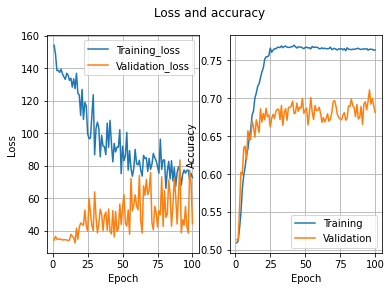

Validation acc: 0.6939
Validation AUC: 0.6961

Start of epoch 0
Training loss (for one batch) at step 0: 693.8319, Accuracy: 0.4766
Training loss (for one batch) at step 10: 578.8286, Accuracy: 0.5142
Training loss (for one batch) at step 20: 541.0170, Accuracy: 0.5153
Training loss (for one batch) at step 30: 535.6951, Accuracy: 0.5189
Training loss (for one batch) at step 40: 485.5503, Accuracy: 0.5160
Training loss (for one batch) at step 50: 499.8648, Accuracy: 0.5195
Training loss (for one batch) at step 60: 480.9888, Accuracy: 0.5195
Training loss (for one batch) at step 70: 493.3076, Accuracy: 0.5156
Training loss (for one batch) at step 80: 482.5076, Accuracy: 0.5183
Training loss (for one batch) at step 90: 474.3747, Accuracy: 0.5192
Training loss (for one batch) at step 100: 465.2343, Accuracy: 0.5176
Training loss (for one batch) at step 110: 465.3364, Accuracy: 0.5161
---- Training ----
Training loss: 144.2230
Training acc over epoch: 0.5161
---- Validation ----
Validation 

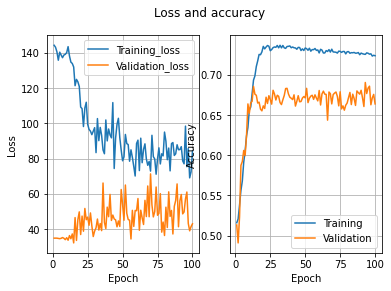

Validation acc: 0.6535
Validation AUC: 0.6545

Start of epoch 0
Training loss (for one batch) at step 0: 630.4998, Accuracy: 0.4375
Training loss (for one batch) at step 10: 564.4643, Accuracy: 0.5043
Training loss (for one batch) at step 20: 523.3744, Accuracy: 0.5145
Training loss (for one batch) at step 30: 495.0690, Accuracy: 0.5149
Training loss (for one batch) at step 40: 489.2289, Accuracy: 0.5109
Training loss (for one batch) at step 50: 501.5422, Accuracy: 0.5130
Training loss (for one batch) at step 60: 490.3276, Accuracy: 0.5147
Training loss (for one batch) at step 70: 471.0157, Accuracy: 0.5133
Training loss (for one batch) at step 80: 465.9543, Accuracy: 0.5143
Training loss (for one batch) at step 90: 458.3671, Accuracy: 0.5153
Training loss (for one batch) at step 100: 455.4453, Accuracy: 0.5128
Training loss (for one batch) at step 110: 460.1530, Accuracy: 0.5165
---- Training ----
Training loss: 145.7478
Training acc over epoch: 0.5177
---- Validation ----
Validation 

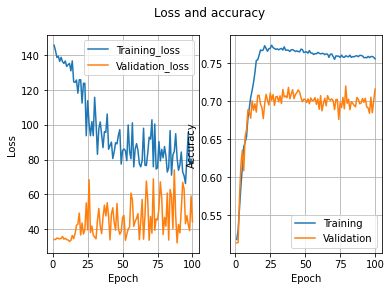

Validation acc: 0.7087
Validation AUC: 0.7106

Start of epoch 0
Training loss (for one batch) at step 0: 628.1870, Accuracy: 0.5078
Training loss (for one batch) at step 10: 577.8608, Accuracy: 0.4901
Training loss (for one batch) at step 20: 537.4642, Accuracy: 0.5045
Training loss (for one batch) at step 30: 508.4905, Accuracy: 0.5093
Training loss (for one batch) at step 40: 492.2657, Accuracy: 0.5053
Training loss (for one batch) at step 50: 496.1004, Accuracy: 0.5051
Training loss (for one batch) at step 60: 482.5640, Accuracy: 0.5069
Training loss (for one batch) at step 70: 497.0506, Accuracy: 0.5076
Training loss (for one batch) at step 80: 475.4393, Accuracy: 0.5081
Training loss (for one batch) at step 90: 478.4634, Accuracy: 0.5064
Training loss (for one batch) at step 100: 479.2246, Accuracy: 0.5052
Training loss (for one batch) at step 110: 466.7251, Accuracy: 0.5047
---- Training ----
Training loss: 143.9710
Training acc over epoch: 0.5054
---- Validation ----
Validation 

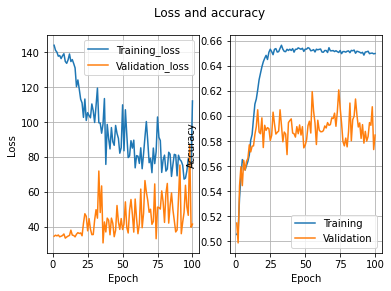

Validation acc: 0.5868
Validation AUC: 0.5900

Start of epoch 0
Training loss (for one batch) at step 0: 692.2372, Accuracy: 0.5078
Training loss (for one batch) at step 10: 629.3203, Accuracy: 0.5668
Training loss (for one batch) at step 20: 588.2375, Accuracy: 0.5413
Training loss (for one batch) at step 30: 532.3591, Accuracy: 0.5315
Training loss (for one batch) at step 40: 524.3278, Accuracy: 0.5276
Training loss (for one batch) at step 50: 517.4301, Accuracy: 0.5306
Training loss (for one batch) at step 60: 527.5547, Accuracy: 0.5336
Training loss (for one batch) at step 70: 479.6271, Accuracy: 0.5336
Training loss (for one batch) at step 80: 500.4022, Accuracy: 0.5308
Training loss (for one batch) at step 90: 488.1693, Accuracy: 0.5267
Training loss (for one batch) at step 100: 498.9133, Accuracy: 0.5253
Training loss (for one batch) at step 110: 471.6760, Accuracy: 0.5258
---- Training ----
Training loss: 147.7240
Training acc over epoch: 0.5263
---- Validation ----
Validation 

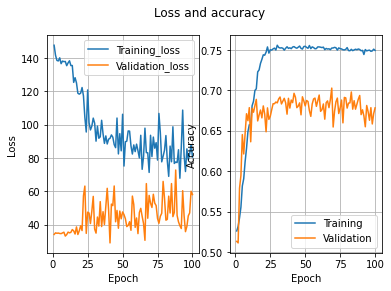

Validation acc: 0.6874
Validation AUC: 0.6872

Start of epoch 0
Training loss (for one batch) at step 0: 622.2669, Accuracy: 0.5000
Training loss (for one batch) at step 10: 561.4722, Accuracy: 0.4950
Training loss (for one batch) at step 20: 528.0536, Accuracy: 0.4914
Training loss (for one batch) at step 30: 535.8940, Accuracy: 0.4884
Training loss (for one batch) at step 40: 541.7325, Accuracy: 0.4952
Training loss (for one batch) at step 50: 487.1022, Accuracy: 0.5011
Training loss (for one batch) at step 60: 520.9497, Accuracy: 0.4996
Training loss (for one batch) at step 70: 491.9175, Accuracy: 0.5012
Training loss (for one batch) at step 80: 483.0466, Accuracy: 0.5032
Training loss (for one batch) at step 90: 477.5577, Accuracy: 0.5068
Training loss (for one batch) at step 100: 470.7304, Accuracy: 0.5085
Training loss (for one batch) at step 110: 469.1784, Accuracy: 0.5092
---- Training ----
Training loss: 146.8497
Training acc over epoch: 0.5101
---- Validation ----
Validation 

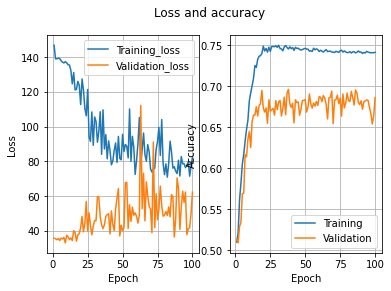

Validation acc: 0.6786
Validation AUC: 0.6810

Start of epoch 0
Training loss (for one batch) at step 0: 595.0266, Accuracy: 0.6328
Training loss (for one batch) at step 10: 557.4879, Accuracy: 0.4943
Training loss (for one batch) at step 20: 542.6710, Accuracy: 0.4851
Training loss (for one batch) at step 30: 522.1675, Accuracy: 0.4932
Training loss (for one batch) at step 40: 537.5087, Accuracy: 0.4981
Training loss (for one batch) at step 50: 509.9998, Accuracy: 0.5026
Training loss (for one batch) at step 60: 513.2633, Accuracy: 0.5085
Training loss (for one batch) at step 70: 500.7504, Accuracy: 0.5133
Training loss (for one batch) at step 80: 495.7657, Accuracy: 0.5131
Training loss (for one batch) at step 90: 504.8313, Accuracy: 0.5121
Training loss (for one batch) at step 100: 478.6949, Accuracy: 0.5128
Training loss (for one batch) at step 110: 468.0410, Accuracy: 0.5136
---- Training ----
Training loss: 154.0699
Training acc over epoch: 0.5145
---- Validation ----
Validation 

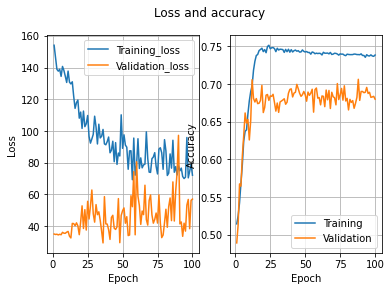

Validation acc: 0.6771
Validation AUC: 0.6774

Start of epoch 0
Training loss (for one batch) at step 0: 713.2382, Accuracy: 0.4922
Training loss (for one batch) at step 10: 565.6422, Accuracy: 0.4972
Training loss (for one batch) at step 20: 572.4861, Accuracy: 0.5078
Training loss (for one batch) at step 30: 518.8548, Accuracy: 0.5154
Training loss (for one batch) at step 40: 494.2432, Accuracy: 0.5116
Training loss (for one batch) at step 50: 501.1718, Accuracy: 0.5103
Training loss (for one batch) at step 60: 485.5132, Accuracy: 0.5118
Training loss (for one batch) at step 70: 479.9048, Accuracy: 0.5109
Training loss (for one batch) at step 80: 483.5883, Accuracy: 0.5133
Training loss (for one batch) at step 90: 474.5203, Accuracy: 0.5149
Training loss (for one batch) at step 100: 482.2653, Accuracy: 0.5173
Training loss (for one batch) at step 110: 461.4325, Accuracy: 0.5187
---- Training ----
Training loss: 145.1949
Training acc over epoch: 0.5198
---- Validation ----
Validation 

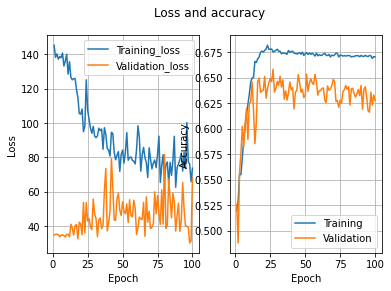

Validation acc: 0.6260
Validation AUC: 0.6258

Start of epoch 0
Training loss (for one batch) at step 0: 662.4262, Accuracy: 0.4766
Training loss (for one batch) at step 10: 545.7134, Accuracy: 0.5263
Training loss (for one batch) at step 20: 514.3978, Accuracy: 0.5182
Training loss (for one batch) at step 30: 498.8600, Accuracy: 0.5161
Training loss (for one batch) at step 40: 487.9665, Accuracy: 0.5185
Training loss (for one batch) at step 50: 511.1759, Accuracy: 0.5095
Training loss (for one batch) at step 60: 483.5115, Accuracy: 0.5115
Training loss (for one batch) at step 70: 480.3833, Accuracy: 0.5100
Training loss (for one batch) at step 80: 463.9382, Accuracy: 0.5122
Training loss (for one batch) at step 90: 458.9432, Accuracy: 0.5123
Training loss (for one batch) at step 100: 469.2434, Accuracy: 0.5105
Training loss (for one batch) at step 110: 471.4868, Accuracy: 0.5100
---- Training ----
Training loss: 139.2115
Training acc over epoch: 0.5103
---- Validation ----
Validation 

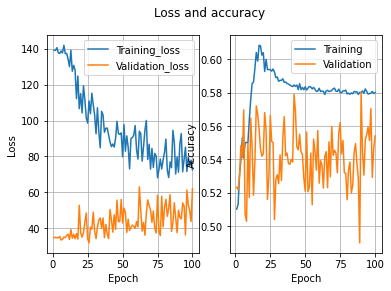

Validation acc: 0.5447
Validation AUC: 0.5453

Start of epoch 0
Training loss (for one batch) at step 0: 677.5400, Accuracy: 0.5078
Training loss (for one batch) at step 10: 527.2578, Accuracy: 0.5007
Training loss (for one batch) at step 20: 527.0426, Accuracy: 0.4963
Training loss (for one batch) at step 30: 514.4397, Accuracy: 0.5008
Training loss (for one batch) at step 40: 509.0315, Accuracy: 0.5063
Training loss (for one batch) at step 50: 509.8824, Accuracy: 0.5126
Training loss (for one batch) at step 60: 487.3205, Accuracy: 0.5127
Training loss (for one batch) at step 70: 477.6264, Accuracy: 0.5114
Training loss (for one batch) at step 80: 477.3275, Accuracy: 0.5096
Training loss (for one batch) at step 90: 467.2506, Accuracy: 0.5116
Training loss (for one batch) at step 100: 467.6099, Accuracy: 0.5115
Training loss (for one batch) at step 110: 465.3520, Accuracy: 0.5123
---- Training ----
Training loss: 147.7681
Training acc over epoch: 0.5105
---- Validation ----
Validation 

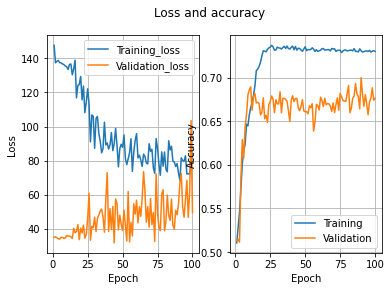

Validation acc: 0.6896
Validation AUC: 0.6901


In [19]:
#model = create_model()
K=2
R=5
NUM_RUNS = 10
N_EPOCHS = 100
val_acc = np.zeros(NUM_RUNS)
AUC= np.zeros(NUM_RUNS)

for i in range(NUM_RUNS):
  MA = MultipleAnnotators_Classification(2, 5, 0.1)
  model =  create_model()
  model = MA.fit(model, train_batches_MA, val_batches_MA, N_EPOCHS)
  #model = MA.fit(model, Data_train_MA, N_EPOCHS)
  val_acc[i] = MA.eval_model(test_batches_MA)
  print("Validation acc: %.4f" % (float(val_acc[i]),))
    
 #AUC =======================
  val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
  for x_batch_val, y_batch_val in test_batches_MA:
      val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
      val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))

  val_AUC = val_AUC_metric.result()
  val_AUC_metric.reset_states()
  val_AUC = val_AUC.numpy()
  print("Validation AUC: %.4f" % (float(val_AUC),))
  AUC[i] = val_AUC
  #===================================================

import pandas as pd
df = pd.DataFrame(val_acc)
#df.to_csv('/content/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output

In [20]:
val_acc

array([0.6938951 , 0.65348238, 0.70872742, 0.58684438, 0.68744624,
       0.67863286, 0.67712814, 0.62596732, 0.54471195, 0.68959588])

In [21]:
AUC

array([0.69611442, 0.65454608, 0.71057403, 0.58999997, 0.68717086,
       0.68096101, 0.67741001, 0.62581247, 0.5452823 , 0.69012088])

In [22]:
print('Average Accuracy: ', np.round(val_acc.mean(),4)*100) 
print('Average std: ',np.round(np.std(val_acc),4)*100)


Average Accuracy:  65.46
Average std:  5.029999999999999


In [23]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  65.58
Average std:  5.029999999999999


In [24]:
# # accuracy
# val_acc_GCCE  = np.zeros(NUM_RUNS)

# for i in range(len(classification_report_r)):
   
#   val_acc_GCCE[i] = classification_report_r[i]['accuracy']


In [25]:
val_acc

array([0.6938951 , 0.65348238, 0.70872742, 0.58684438, 0.68744624,
       0.67863286, 0.67712814, 0.62596732, 0.54471195, 0.68959588])

In [26]:
print('Average Accuracy: ', np.round(val_acc.mean(),4)*100) 

Average Accuracy:  65.46


In [27]:
# y_test = np.asarray([aux[1].numpy() for aux  in validation_data])
# X_test = np.asarray([aux[0].numpy() for aux  in validation_data])
# # N = len(y_true)
# # #test_batches_MA
# # aux1 = [test_batches_MA[i][0] for i in range(N)]
# # aux2 = [test_batches_MA[i][1] for i in range(N)]

In [28]:
# X_test.shape

In [29]:
# pred = model.predict(X_test)
# pred[:, :2].argmax(axis=1)
# print(classification_report(pred[:, :2].argmax(axis=1), y_test ))


In [30]:
val_acc.mean()

0.6546431660652161

In [31]:
print('STD Accuracy: ', np.round(np.std(val_acc),4)*100) 

STD Accuracy:  5.029999999999999


MC droput run this in a loop with training layer set to True.

In [32]:
# y_probas = np.stack([MA.eval_model((test_batches,training=True) # se activa training en True para que el Dropout se aplique
#                    for sample in range(100)])

# y_proba = y_probas.mean(axis=0)
# y_std = y_probas.std(axis=0)
# y_probas.shape

In [33]:
# y_ped =np.argmax(y_proba,axis=1)
# accuracy=np.sum(y_pred==test_label)/len(test_label)
# accuracy

In [34]:
   
# r1 = np.mean(val_acc)
# print("\nMean: ", r1)
  
# r2 = np.std(val_acc)
# print("\nstd: ", r2)
  
# r3 = np.var(val_acc)
# print("\nvariance: ", r3)
# #MA.eval_model(test_batches)

In [35]:
# val_acc

VGG19 --> acc:0.8613  --> 0.894454 --> 0.772356